# DMs Guild Sales Analysis

This notebook analyzes sales data from DMs Guild, looking at trends, top performers, and revenue patterns.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install matplotlib pandas numpy seaborn google-api-python-client google-auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Set style for better visualizations
plt.style.use('default')  # Use default style first
sns.set_theme()  # Apply seaborn styling
sns.set_palette("husl")  # Set color palette

# Verify imports worked
print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

def load_sheet_data(spreadsheet_id, credentials_path):
#     """Load data from Google Sheet into DataFrame with column verification."""
#     creds = service_account.Credentials.from_service_account_file(
#         credentials_path,
#         scopes=['https://www.googleapis.com/auth/spreadsheets.readonly']
#     )

#     service = build('sheets', 'v4', credentials=creds)

#     # Get all data from Sheet1
#     result = service.spreadsheets().values().get(
#         spreadsheetId=spreadsheet_id,
#         range='Sheet1'
#     ).execute()

#     values = result.get('values', [])
#     if not values:
#         raise ValueError("No data found in sheet")

#     # Print column names for debugging
#     columns = values[0]
#     print("\nAvailable columns in sheet:")
#     for i, col in enumerate(columns):
#         print(f"{i}: {col}")
    # Authenticate using Colab's built-in method
    #auth.authenticate_user()

    # 3. Authenticate and get credentials
    auth.authenticate_user()
    creds, _ = default()

    # 4. Create client
    gc = gspread.authorize(creds)

    # 5. Open spreadsheet and get worksheet
    spreadsheet = gc.open('dms_guild_sales_testing')  # Replace with your sheet name
    worksheet = spreadsheet.sheet1  # Gets first sheet, or use get_worksheet(0)

    # 6. Convert to DataFrame
    df = pd.DataFrame(worksheet.get_all_records())

    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Units Sold'] = pd.to_numeric(df['Units Sold'], errors='coerce')
    df['Your Royalties'] = df['Your Royalties'].str.replace('$', '', regex=False)
    df['Your Royalties'] = pd.to_numeric(df['Your Royalties'], errors='coerce')

    return df

def data_quality_checks(df):
    # Check for valid months
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    for value in df['Month']:
        if value not in months:
            raise ValueError(f"Invalid month value: {value}")

    #check for valid years
    for value in df['Year']:
        if value < 2016 or value > 2024:
            raise ValueError(f"Invalid year value: {value}")

    # check for valid dm's guild titles
    titles = [
    "A DM's Guide to the Joy of Extradimensional Spaces",
    "Betrayal in the Hartsvale",
    "Dark Redemption",
    "DM's Guide to Dragon of Icespire Peak",
    "DM's Guide to Light of Xaryxis from the Spelljammer Campaign Setting",
    "DM's Guide to Turn of Fortune's Wheel, Part 1",
    "DM's Guide to Turn of Fortune's Wheel, Part 2",
    "Ghosts of Saltmarsh Encounters",
    "Return to White Plume Mountain 5E Conversion",
    "The Mystery at Dreary's Well",
    "The Town of ManyAxes",
    "5e Conversion for Misplaced Spirit from the 2e Planecape Campaign Setting"
    ]

    for value in df['Title']:
        if value not in titles:
            raise ValueError(f"Invalid DM's Guild Title value: {value}")

     # Check for NaN values in Units Sold and Your Royalties
    if df['Units Sold'].isna().any():
        nan_rows = df[df['Units Sold'].isna()]
        raise ValueError(f"Found NaN values in Units Sold column:\n{nan_rows}")

    if df['Your Royalties'].isna().any():
        nan_rows = df[df['Your Royalties'].isna()]
        raise ValueError(f"Found NaN values in Your Royalties column:\n{nan_rows}")

    # Check for negative values in Units Sold and Your Royalties
    if (df['Units Sold'] < 0).any():
        neg_rows = df[df['Units Sold'] < 0]
        raise ValueError(f"Found negative values in Units Sold column:\n{neg_rows}")

    if (df['Your Royalties'] < 0).any():
        neg_rows = df[df['Your Royalties'] < 0]
        raise ValueError(f"Found negative values in Your Royalties column:\n{neg_rows}")



# Load and check the data
SPREADSHEET_ID = '1mtdp0DCDFWEVJPlb44MuNdqJnZCV9IDhPbFnDyj1G1Q'
CREDENTIALS_PATH = 'arctic-sign-398401-520cfea4d1ef.json'

# Load the data
df = load_sheet_data(SPREADSHEET_ID, CREDENTIALS_PATH)

data_quality_checks(df)

print("\nDataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 254 non-null    object 
 1   Year                  254 non-null    int64  
 2   Publisher             254 non-null    object 
 3   Title                 254 non-null    object 
 4   SKU                   254 non-null    object 
 5   Units Sold            254 non-null    int64  
 6   Net                   254 non-null    object 
 7   Current Royalty Rate  254 non-null    object 
 8   Your Royalties        254 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 18.0+ KB
None


## Monthly Revenue Analysis

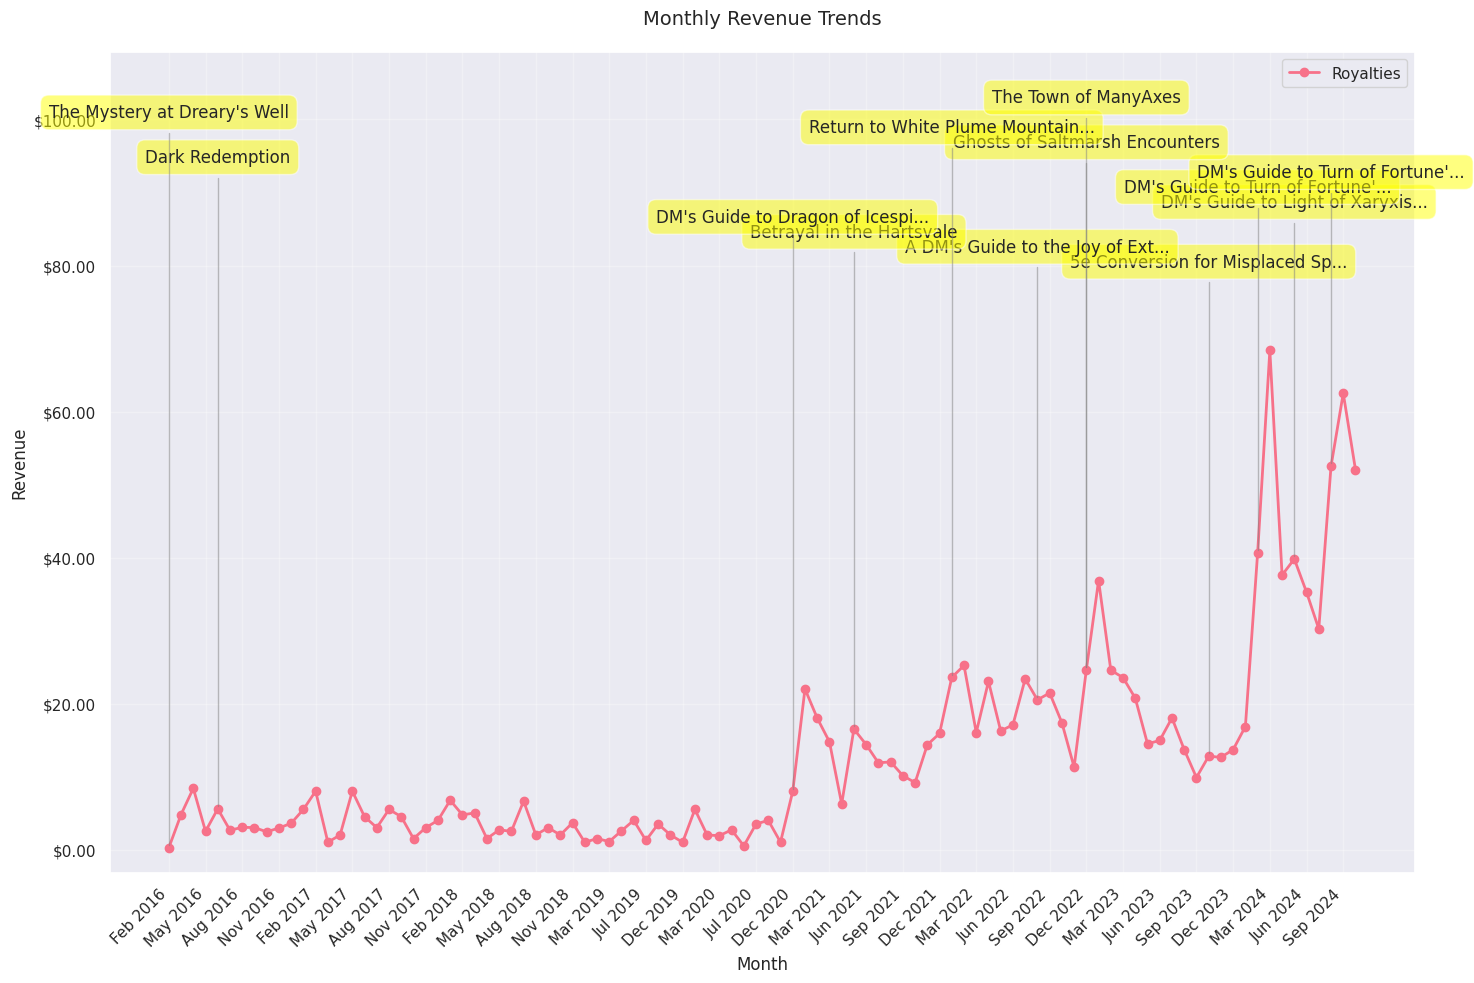


First sale dates for each title:
                                                                    Title Month-Year
                                             The Mystery at Dreary's Well 2016-02-01
                                                          Dark Redemption 2016-06-01
                                    DM's Guide to Dragon of Icespire Peak 2020-12-01
                                                Betrayal in the Hartsvale 2021-05-01
                             Return to White Plume Mountain 5E Conversion 2022-01-01
                       A DM's Guide to the Joy of Extradimensional Spaces 2022-08-01
                                           Ghosts of Saltmarsh Encounters 2022-12-01
                                                     The Town of ManyAxes 2022-12-01
5e Conversion for Misplaced Spirit from the 2e Planecape Campaign Setting 2023-10-01
                            DM's Guide to Turn of Fortune's Wheel, Part 1 2024-02-01
     DM's Guide to Light of Xar

In [ ]:
# Create month-year combinations and convert to datetime for sorting
df['Month-Year'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str), format='%B %Y')

# Find first sale month for each title
first_sales = df[df['Units Sold'] > 0].groupby('Title')['Month-Year'].min().reset_index()
first_sales = first_sales.merge(df[['Month-Year', 'Title', 'Your Royalties', 'Units Sold']],
                               on=['Month-Year', 'Title'])

# Group by Month-Year and calculate totals
monthly_revenue = df.groupby('Month-Year').agg({
    'Your Royalties': 'sum',
    'Units Sold': 'sum'
}).reset_index()

# Sort by date
monthly_revenue = monthly_revenue.sort_values('Month-Year')

# Create formatted Month-Year string for plotting
monthly_revenue['Month-Year-Str'] = monthly_revenue['Month-Year'].dt.strftime('%b %Y')

# Plot monthly trends
plt.figure(figsize=(15, 10))  # Made even taller for annotations

# Plot with dollar formatting for y-axis
plt.plot(range(len(monthly_revenue)), monthly_revenue['Your Royalties'],
         marker='o', label='Royalties', linewidth=2)

# Create x-axis labels - show only every 3rd month
x_ticks = range(len(monthly_revenue))
x_labels = monthly_revenue['Month-Year-Str']
shown_indices = x_ticks[::3]
shown_labels = x_labels[::3]

plt.xticks(shown_indices, shown_labels,
           rotation=45,
           ha='right')

# Format y-axis with dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))

# Add labels and title
plt.title('Monthly Revenue Trends', pad=20, size=14)
plt.ylabel('Revenue', size=12)
plt.xlabel('Month', size=12)

# Calculate y-axis limits for better annotation placement
y_min, y_max = plt.ylim()
y_range = y_max - y_min
plt.ylim(y_min, y_max + y_range * 0.5)  # Add 50% more space at top

# Add annotations for first sales
# Space annotations vertically
vertical_positions = np.linspace(y_max + (y_range * 0.1), y_max + (y_range * 0.4), len(first_sales))
for (_, row), vert_pos in zip(first_sales.iterrows(), vertical_positions):
    # Find the index in monthly_revenue that matches this date
    idx = monthly_revenue[monthly_revenue['Month-Year'] == row['Month-Year']].index[0]

    # Get y-value from monthly revenue
    y_value = monthly_revenue.loc[idx, 'Your Royalties']

    # Create shortened title for annotation
    short_title = row['Title'][:30] + '...' if len(row['Title']) > 30 else row['Title']

    # Add annotation with longer arrow
    plt.annotate(f'{short_title}',
                xy=(idx, y_value),  # Start at data point
                xytext=(idx, vert_pos),  # Text positioned above
                ha='center',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(
                    arrowstyle='-',
                    connectionstyle='angle,angleA=90,angleB=0,rad=0',
                    color='gray',
                    alpha=0.5
                ))

# Adjust grid
plt.grid(True, alpha=0.3)
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Print first sale dates for each title
print("\nFirst sale dates for each title:")
print(first_sales[['Title', 'Month-Year']].sort_values('Month-Year').to_string(index=False))

## Top Performing Products

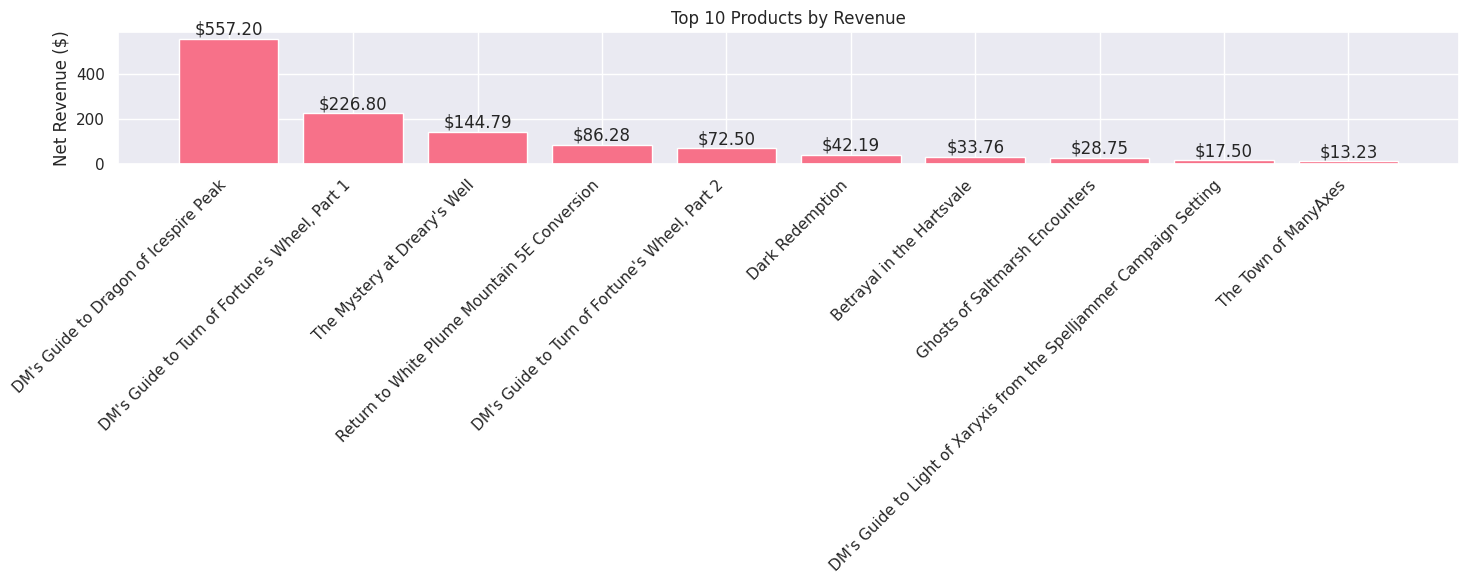


Top 10 Products Details:
                                                               Title  Units Sold  Your Royalties
                               DM's Guide to Dragon of Icespire Peak        1027          557.20
                       DM's Guide to Turn of Fortune's Wheel, Part 1         156          226.80
                                        The Mystery at Dreary's Well         170          144.79
                        Return to White Plume Mountain 5E Conversion          40           86.28
                       DM's Guide to Turn of Fortune's Wheel, Part 2          29           72.50
                                                     Dark Redemption          86           42.19
                                           Betrayal in the Hartsvale          23           33.76
                                      Ghosts of Saltmarsh Encounters          61           28.75
DM's Guide to Light of Xaryxis from the Spelljammer Campaign Setting           7           17.50
    

In [ ]:
# Aggregate by product
product_performance = df.groupby('Title').agg({
    'Units Sold': 'sum',
    'Your Royalties': 'sum'
}).reset_index()

# Sort by revenue and get top 10
top_10_products = product_performance.nlargest(10, 'Your Royalties')

# Create bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(top_10_products)), top_10_products['Your Royalties'])
plt.title('Top 10 Products by Revenue')
plt.xticks(range(len(top_10_products)), top_10_products['Title'], rotation=45, ha='right')
plt.ylabel('Net Revenue ($)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed stats for top products
print("\nTop 10 Products Details:")
print(top_10_products.to_string(index=False))

## Year-over-Year Comparison

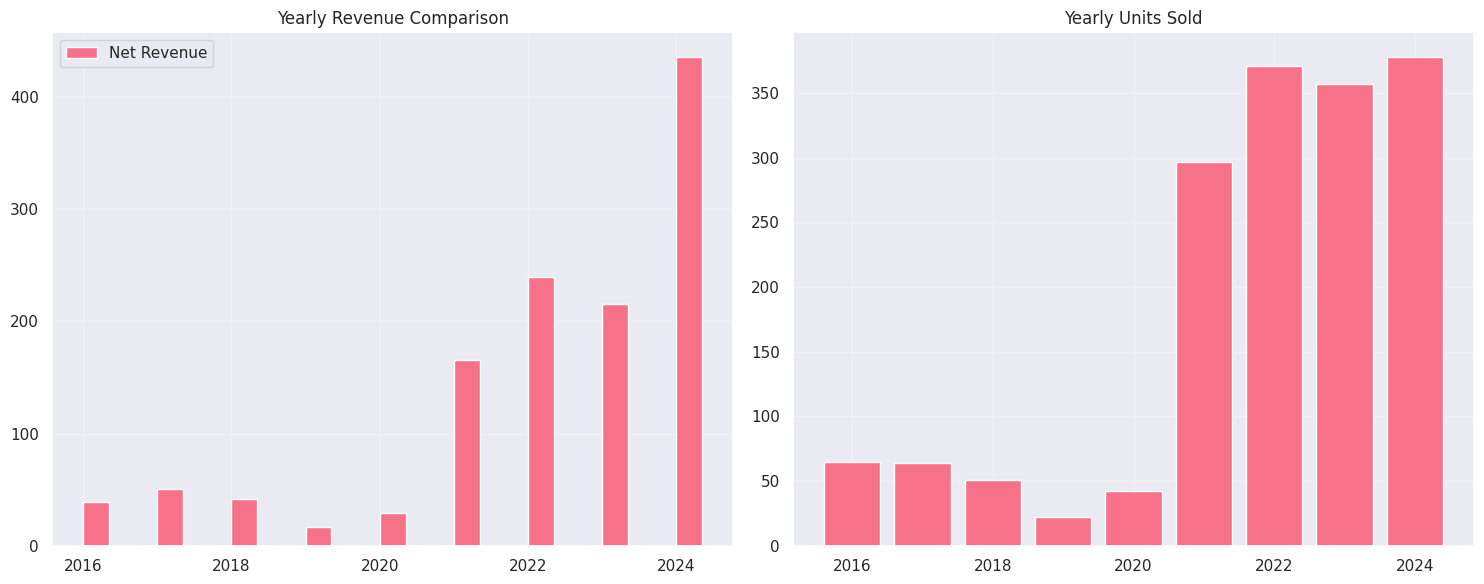


Year-over-Year Growth:
   Year  Your Royalties  Units Sold  Revenue_Growth  Units_Growth
0  2016           39.20          65             NaN           NaN
1  2017           50.50          64           28.83         -1.54
2  2018           41.52          51          -17.78        -20.31
3  2019           16.91          22          -59.27        -56.86
4  2020           29.09          42           72.03         90.91
5  2021          165.33         297          468.34        607.14
6  2022          239.83         371           45.06         24.92
7  2023          215.83         357          -10.01         -3.77
8  2024          435.74         378          101.89          5.88


In [ ]:
# Calculate yearly totals
yearly_totals = df.groupby('Year').agg({
    'Your Royalties': 'sum',
    'Units Sold': 'sum'
}).reset_index()

# Create year-over-year comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue comparison
width = 0.35
ax1.bar(yearly_totals['Year'] + width/2, yearly_totals['Your Royalties'], width, label='Net Revenue')
ax1.set_title('Yearly Revenue Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Units sold comparison
ax2.bar(yearly_totals['Year'], yearly_totals['Units Sold'])
ax2.set_title('Yearly Units Sold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print year-over-year growth
print("\nYear-over-Year Growth:")
yearly_growth = yearly_totals.copy()
yearly_growth['Revenue_Growth'] = yearly_growth['Your Royalties'].pct_change() * 100
yearly_growth['Units_Growth'] = yearly_growth['Units Sold'].pct_change() * 100
print(yearly_growth.round(2))

# Revenue Per Month Avalable

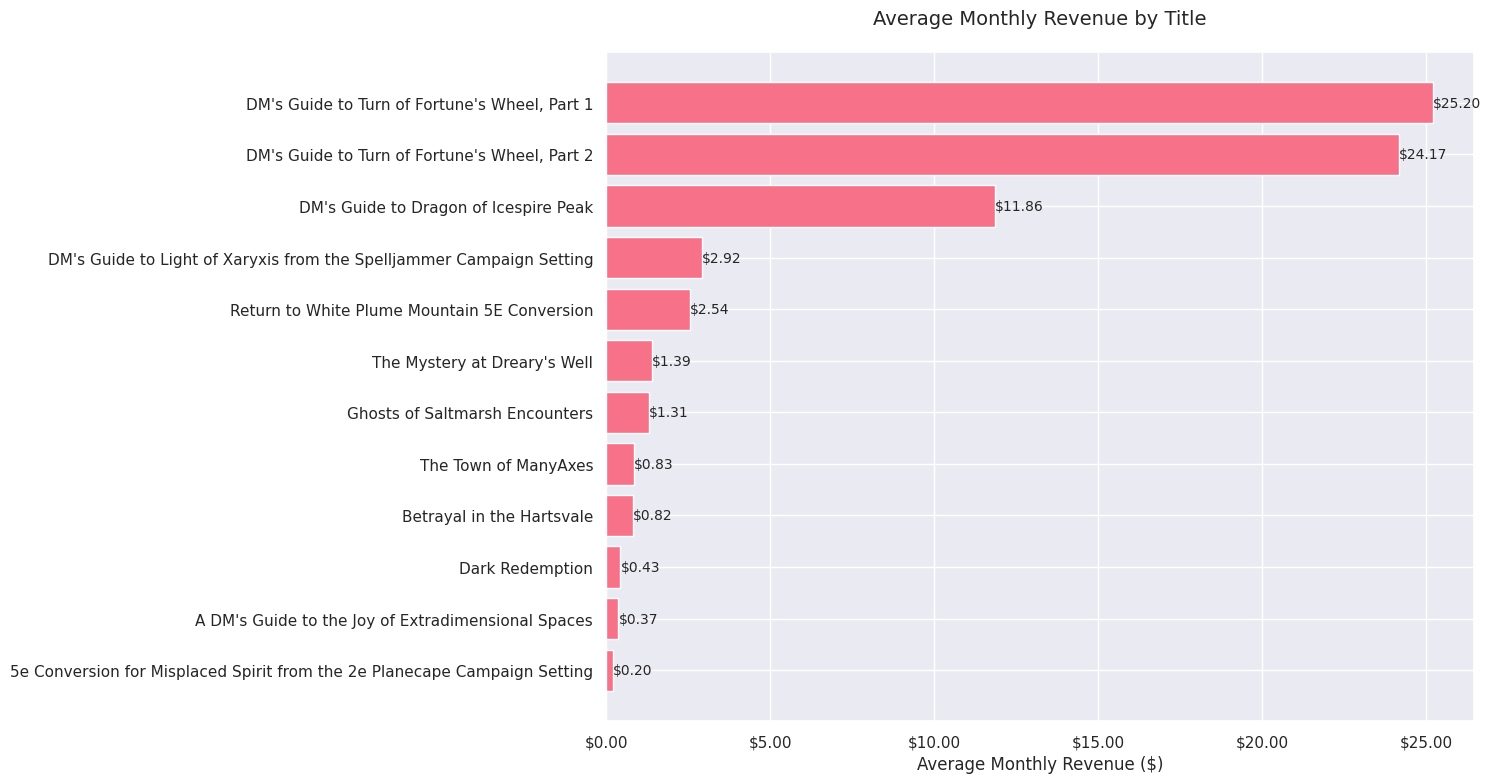


Detailed Title Revenue Analysis:
----------------------------------------------------------------------------------------------------
Title: The Mystery at Dreary's Well
First Sale: February 2016
Months Available: 104
Total Revenue: $144.79
Average Monthly Revenue: $1.39
Revenue Per Unit: $0.85
Total Units Sold: 170
----------------------------------------------------------------------------------------------------
Title: Dark Redemption
First Sale: June 2016
Months Available: 98
Total Revenue: $42.19
Average Monthly Revenue: $0.43
Revenue Per Unit: $0.49
Total Units Sold: 86
----------------------------------------------------------------------------------------------------
Title: DM's Guide to Dragon of Icespire Peak
First Sale: December 2020
Months Available: 47
Total Revenue: $557.20
Average Monthly Revenue: $11.86
Revenue Per Unit: $0.54
Total Units Sold: 1,027
----------------------------------------------------------------------------------------------------
Title: Betrayal in 

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

def analyze_title_revenue(df):
    """
    Analyzes title revenue based on months available and calculates average monthly revenue.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns: Title, Month, Year, Your Royalties, Units Sold

    Returns:
    pandas.DataFrame: Analysis results per title
    pandas.DataFrame: Monthly performance metrics
    """
    # Ensure Month-Year column exists
    if 'Month-Year' not in df.columns:
        df['Month-Year'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str), format='%B %Y')

    # Find first and last sale dates for each title
    title_spans = df.groupby('Title').agg({
        'Month-Year': ['min', 'max']
    }).reset_index()
    title_spans.columns = ['Title', 'First_Sale', 'Last_Sale']


    # Calculate months available for each title
    # Calculate months available for each title
    # Using year and month differences to get accurate month count
    title_spans['Months_Available'] = (
        (title_spans['Last_Sale'].dt.year - title_spans['First_Sale'].dt.year) * 12 +
        (title_spans['Last_Sale'].dt.month - title_spans['First_Sale'].dt.month) + 1
    )

    # Calculate total revenue for each title
    title_revenue = df.groupby('Title').agg({
        'Your Royalties': 'sum',
        'Units Sold': 'sum'
    }).reset_index()

    # Merge spans and revenue
    title_analysis = pd.merge(title_spans, title_revenue, on='Title')

    # Calculate average monthly revenue
    title_analysis['Avg_Monthly_Revenue'] = (title_analysis['Your Royalties'] /
                                           title_analysis['Months_Available']).round(2)

    # Calculate revenue per unit
    title_analysis['Revenue_Per_Unit'] = (title_analysis['Your Royalties'] /
                                         title_analysis['Units Sold']).round(2)

    # Sort by average monthly revenue
    title_analysis = title_analysis.sort_values('Avg_Monthly_Revenue', ascending=False)

    # Calculate monthly performance metrics
    monthly_metrics = df.groupby('Month-Year').agg({
        'Your Royalties': 'sum',
        'Units Sold': 'sum'
    }).reset_index()

    # Calculate running averages
    monthly_metrics['Cumulative_Avg_Revenue'] = (monthly_metrics['Your Royalties'].cumsum() /
                                               (range(1, len(monthly_metrics) + 1)))

    # Calculate month-over-month growth
    monthly_metrics['Revenue_MoM_Growth'] = monthly_metrics['Your Royalties'].pct_change() * 100

    # Sort both DataFrames by date
    monthly_metrics = monthly_metrics.sort_values('Month-Year')
    title_analysis = title_analysis.sort_values('First_Sale')

    return title_analysis, monthly_metrics

def print_title_analysis(title_analysis):
    """
    Prints a formatted analysis report for each title and displays a bar chart of average monthly revenue.
    """
    # Create the bar chart
    plt.figure(figsize=(15, 8))

    # Sort by average monthly revenue descending
    plot_data = title_analysis.sort_values('Avg_Monthly_Revenue', ascending=True)  # Ascending for bottom-to-top

    # Create bars
    bars = plt.barh(plot_data['Title'], plot_data['Avg_Monthly_Revenue'])

    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'${width:,.2f}',
                va='center', ha='left', fontsize=10)

    # Customize the chart
    plt.title('Average Monthly Revenue by Title', pad=20, size=14)
    plt.xlabel('Average Monthly Revenue ($)', size=12)

    # Format x-axis with dollar signs
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed analysis
    print("\nDetailed Title Revenue Analysis:")
    print("-" * 100)
    for _, row in title_analysis.iterrows():
        print(f"Title: {row['Title']}")
        print(f"First Sale: {row['First_Sale'].strftime('%B %Y')}")
        print(f"Months Available: {row['Months_Available']}")
        print(f"Total Revenue: ${row['Your Royalties']:,.2f}")
        print(f"Average Monthly Revenue: ${row['Avg_Monthly_Revenue']:,.2f}")
        print(f"Revenue Per Unit: ${row['Revenue_Per_Unit']:,.2f}")
        print(f"Total Units Sold: {row['Units Sold']:,}")
        print("-" * 100)

# Run the analysis
title_analysis, monthly_metrics = analyze_title_revenue(df)

# Print the detailed analysis
print_title_analysis(title_analysis)

# You can also access specific metrics, for example:
# print("\nTop 5 titles by average monthly revenue:")
# print(title_analysis[['Title', 'Avg_Monthly_Revenue']].head().to_string(index=False))

# Forecasting Future Sales

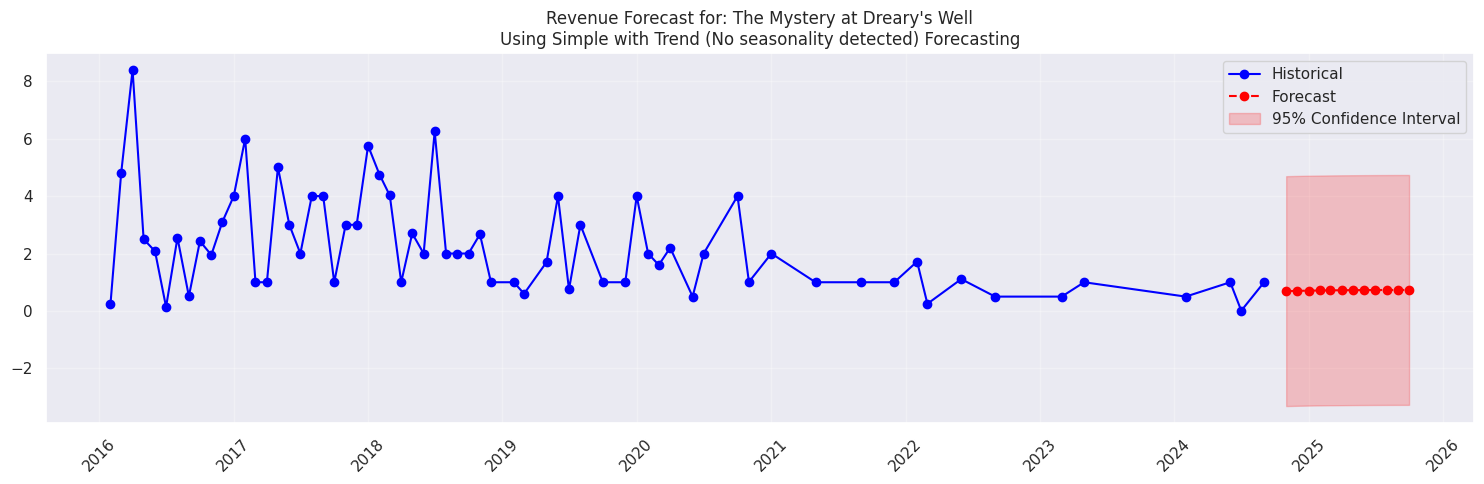

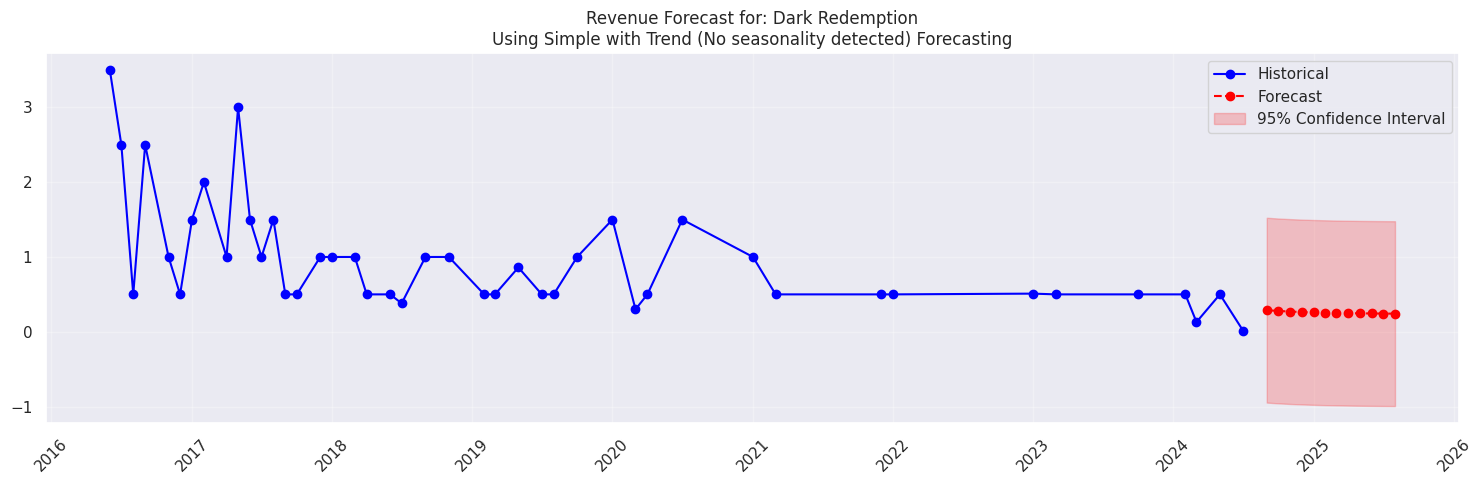

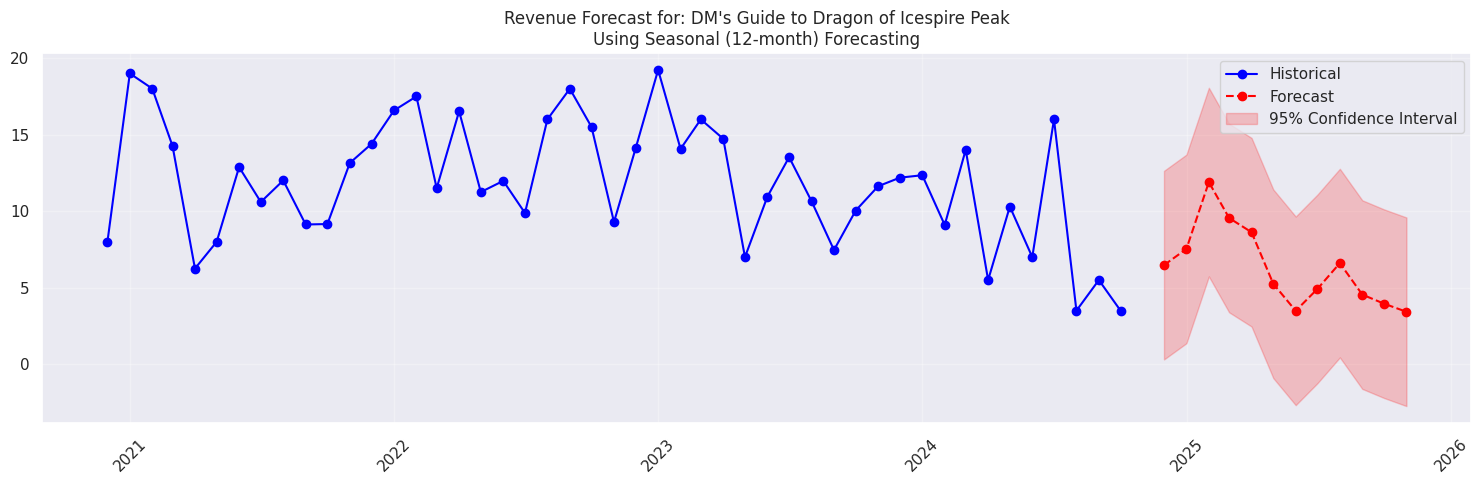

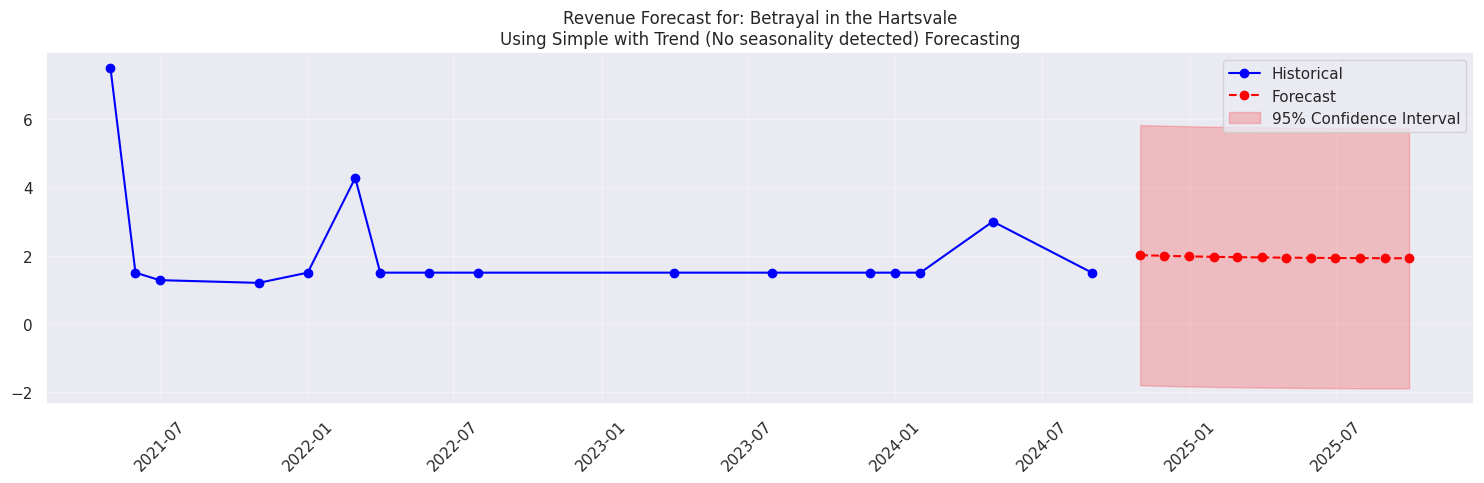

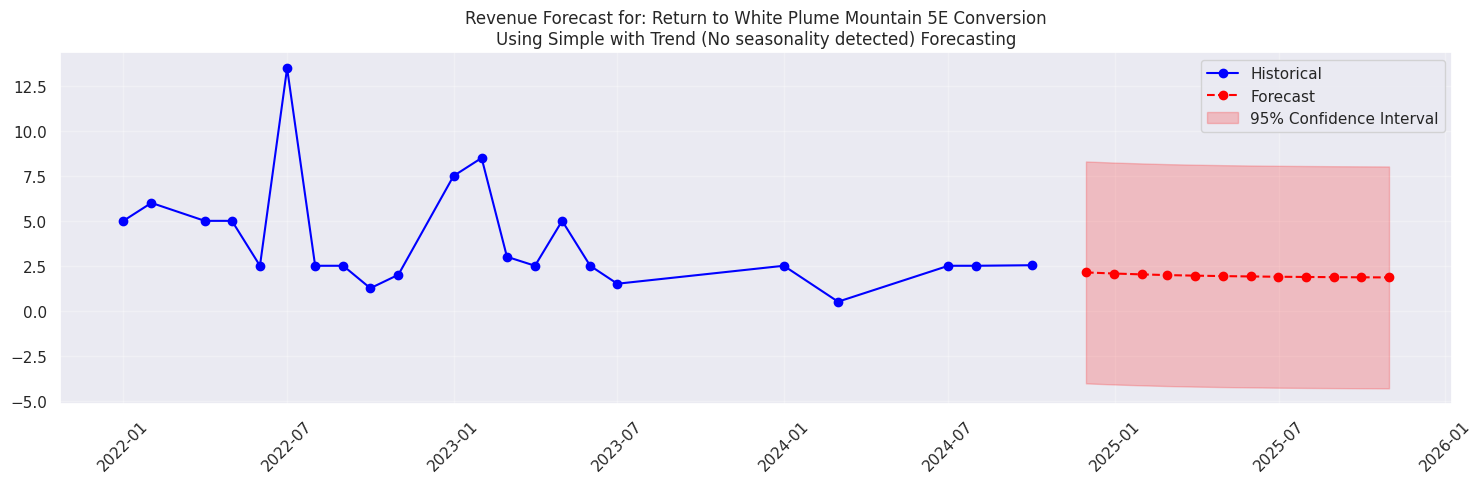

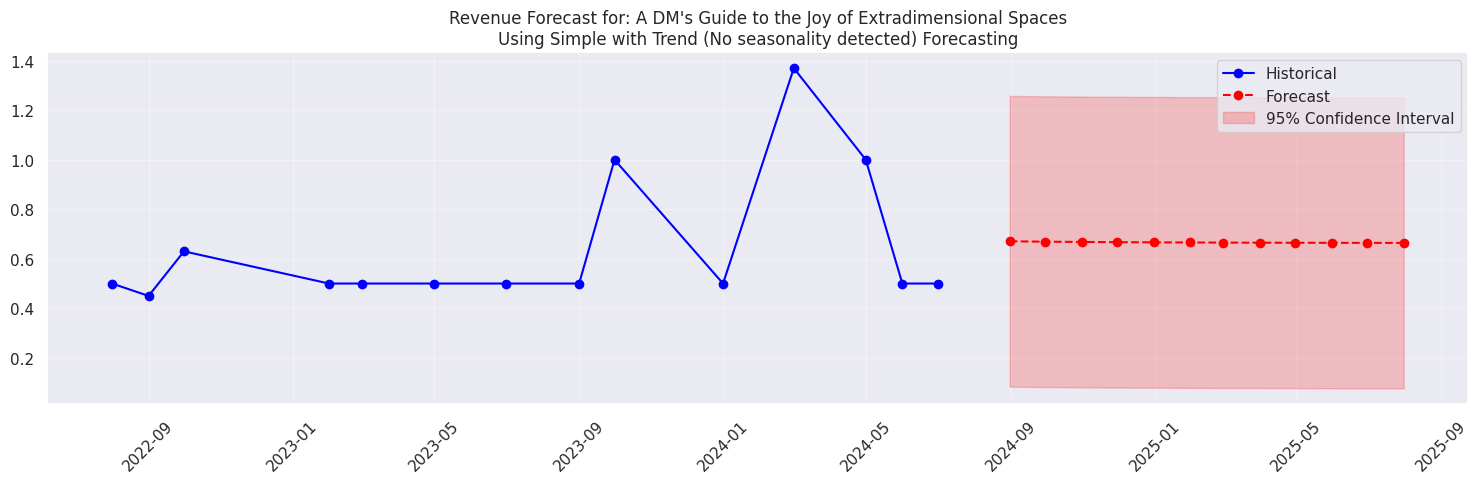

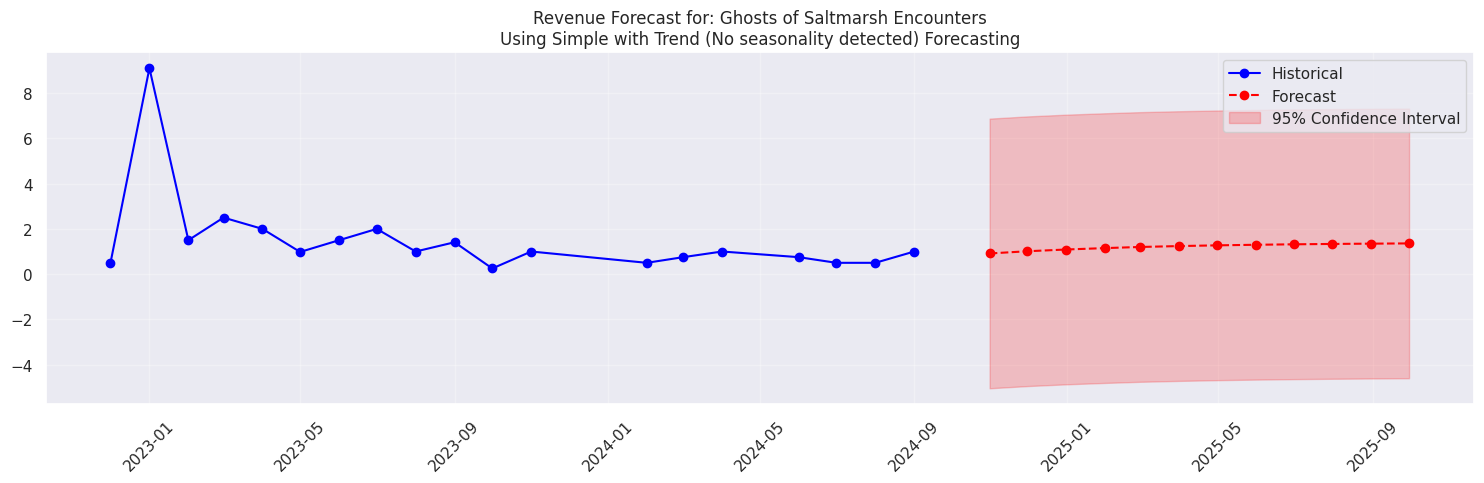

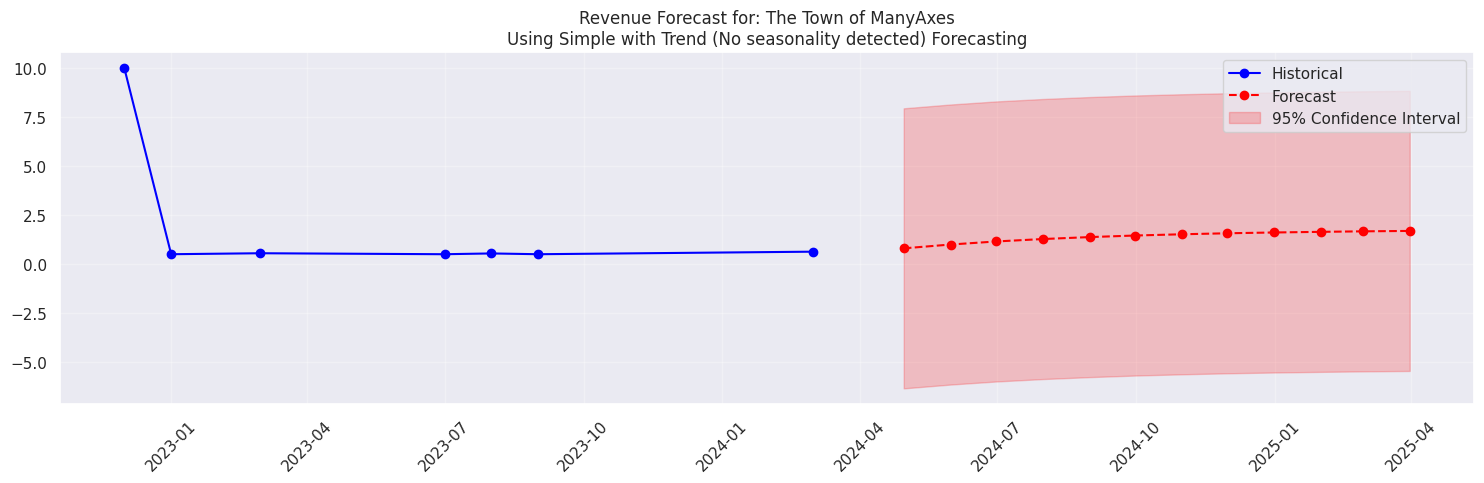

Insufficient data for 5e Conversion for Misplaced Spirit from the 2e Planecape Campaign Setting - needs at least 4 months of history


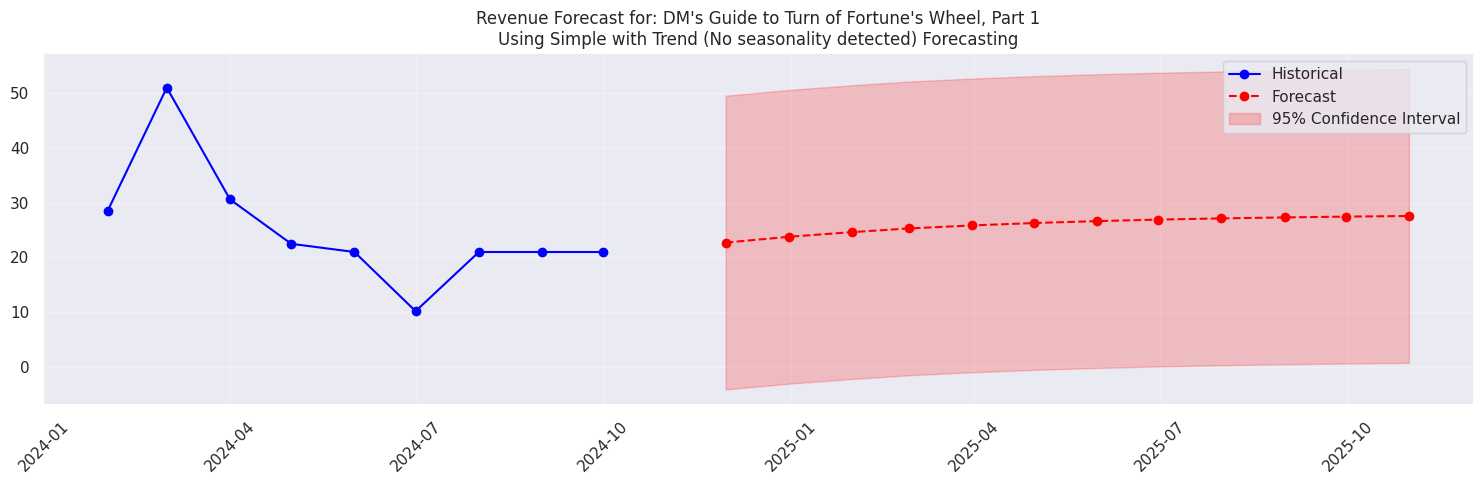

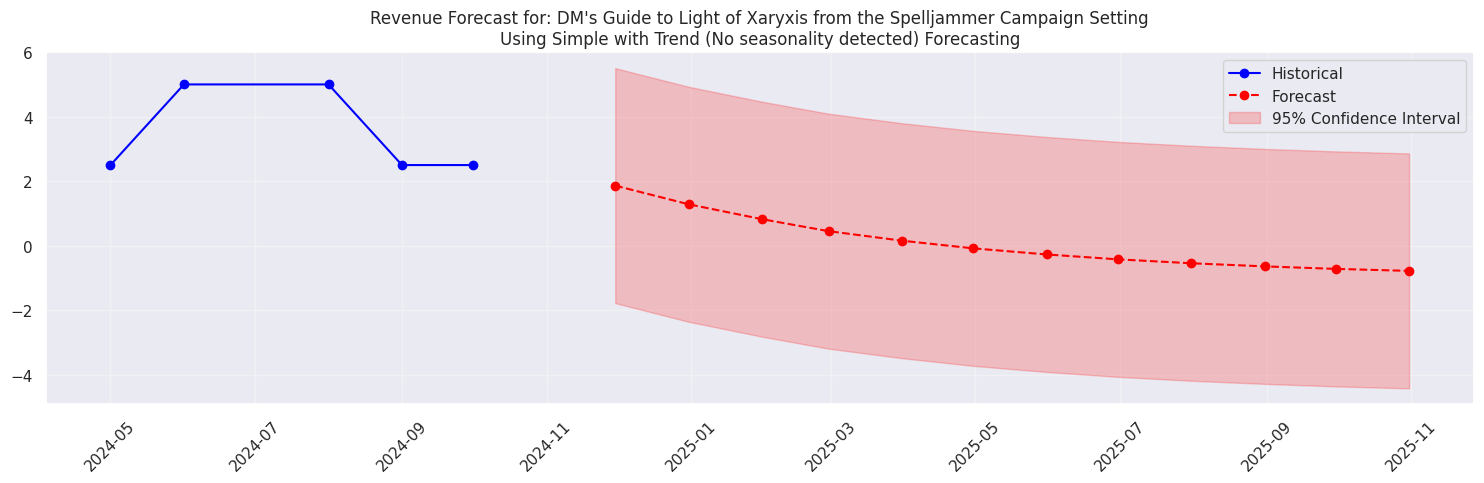

Insufficient data for DM's Guide to Turn of Fortune's Wheel, Part 2 - needs at least 4 months of history

Forecast Summary for 2025:
--------------------------------------------------------------------------------

Title: A DM's Guide to the Joy of Extradimensional Spaces
Forecasting Method Used: Simple with Trend (No seasonality detected)
Projected Total Revenue: $7.99
Average Monthly Revenue: $0.67
Range: $0.66 - $0.67
----------------------------------------

Title: Betrayal in the Hartsvale
Forecasting Method Used: Simple with Trend (No seasonality detected)
Projected Total Revenue: $23.43
Average Monthly Revenue: $1.95
Range: $1.92 - $2.01
----------------------------------------

Title: DM's Guide to Dragon of Icespire Peak
Forecasting Method Used: Seasonal (12-month)
Projected Total Revenue: $76.29
Average Monthly Revenue: $6.36
Range: $3.43 - $11.90
----------------------------------------

Title: DM's Guide to Light of Xaryxis from the Spelljammer Campaign Setting
Forecasting 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose  # Added missing import

def check_seasonality(data, period=12):
    """
    Test if a time series shows significant seasonality.

    Parameters:
    data: Series of sales data
    period: Expected seasonality period (default 12 for monthly data)

    Returns:
    bool: True if significant seasonality is detected
    """
    if len(data) < period * 2:
        return False

    try:
        # Perform seasonal decomposition
        decomposition = seasonal_decompose(
            data,
            period=period,
            model='additive',
            extrapolate_trend='freq'
        )

        # Calculate strength of seasonality
        # Using the ratio of seasonal variance to total variance
        seasonal_strength = np.var(decomposition.seasonal) / np.var(data)

        # Consider seasonal if the seasonal component explains at least 20% of variance
        return seasonal_strength

    except Exception:
        return False


def create_product_forecasts(df, forecast_months=12):
    """
    Creates sales forecasts for each product using adaptive forecasting methods based on data availability.

    Parameters:
    df: DataFrame with columns Title, Month-Year, Your Royalties, Units Sold
    forecast_months: Number of months to forecast (default 12)

    Returns:
    DataFrame with forecasts and visualization
    """
    forecasts = []

    for title in df['Title'].unique():
        title_data = df[df['Title'] == title].copy()
        monthly_sales = title_data.groupby('Month-Year')['Your Royalties'].sum().reset_index()
        monthly_sales = monthly_sales.sort_values('Month-Year')

        data_months = len(monthly_sales)

        if data_months < 4:
            print(f"Insufficient data for {title} - needs at least 4 months of history")
            continue

        try:
            sales_data = monthly_sales['Your Royalties']
            seasonal_strength = check_seasonality(sales_data)
            if data_months >= 24 and seasonal_strength > .2:
              has_seasonality = True
            else:
                has_seasonality = False


            # Choose forecasting method based on data availability and seasonality
            if data_months >= 24 and has_seasonality:
                model = ExponentialSmoothing(
                    sales_data,
                    seasonal_periods=12,
                    trend='add',
                    seasonal='add',
                    damped=True
                ).fit()
                method_used = "Seasonal (12-month)"
            elif data_months >= 12 and has_seasonality:
                seasonal_periods = min(data_months // 2, 12)
                model = ExponentialSmoothing(
                    sales_data,
                    seasonal_periods=seasonal_periods,
                    trend='add',
                    seasonal='add',
                    damped=True
                ).fit()
                method_used = f"Seasonal ({seasonal_periods}-month)"
            else:
                # Use Holt's method instead of SimpleExpSmoothing to capture trend
                model = Holt(sales_data, damped=True).fit()
                method_used = "Simple with Trend (No seasonality detected)"

            # Generate forecast
            forecast = model.forecast(forecast_months)

            # Create future dates
            last_date = monthly_sales['Month-Year'].max()
            future_dates = pd.date_range(
                start=last_date + pd.DateOffset(months=1),
                periods=forecast_months,
                freq='M'
            )

            # Store results
            for date, value in zip(future_dates, forecast):
                forecasts.append({
                    'Title': title,
                    'Month-Year': date,
                    'Forecasted_Revenue': max(0, value),
                    'Type': 'Forecast',
                    'Method': method_used
                })

            # Add historical data
            for date, value in zip(monthly_sales['Month-Year'], monthly_sales['Your Royalties']):
                forecasts.append({
                    'Title': title,
                    'Month-Year': date,
                    'Forecasted_Revenue': value,
                    'Type': 'Historical',
                    'Method': method_used
                })

            # Plot the results
            plt.figure(figsize=(15, 5))
            plt.title(f'Revenue Forecast for: {title}\nUsing {method_used} Forecasting')

            # Plot historical data
            historical_data = monthly_sales['Your Royalties']
            plt.plot(monthly_sales['Month-Year'], historical_data,
                    label='Historical', color='blue', marker='o')

            # Plot forecast
            plt.plot(future_dates, forecast,
                    label='Forecast', color='red', linestyle='--', marker='o')

            # Add confidence intervals
            if hasattr(model, 'fittedvalues'):  # Not all models have fitted values
                mse = mean_squared_error(historical_data, model.fittedvalues)
                std_dev = np.sqrt(mse)
                plt.fill_between(future_dates,
                               forecast - 2*std_dev,
                               forecast + 2*std_dev,
                               color='red', alpha=0.2,
                               label='95% Confidence Interval')

            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error forecasting {title}: {str(e)}")
            continue

    # Create forecast DataFrame
    forecast_df = pd.DataFrame(forecasts)

    if not forecast_df.empty:
        # Calculate summary metrics
        summary = forecast_df[forecast_df['Type'] == 'Forecast'].groupby(['Title', 'Method']).agg({
            'Forecasted_Revenue': ['mean', 'min', 'max', 'sum']
        }).round(2)

        print("\nForecast Summary for 2025:")
        print("-" * 80)
        for (title, method) in summary.index:
            print(f"\nTitle: {title}")
            print(f"Forecasting Method Used: {method}")
            print(f"Projected Total Revenue: ${summary.loc[(title, method), ('Forecasted_Revenue', 'sum')]:,.2f}")
            print(f"Average Monthly Revenue: ${summary.loc[(title, method), ('Forecasted_Revenue', 'mean')]:,.2f}")
            print(f"Range: ${summary.loc[(title, method), ('Forecasted_Revenue', 'min')]:,.2f} - "
                  f"${summary.loc[(title, method), ('Forecasted_Revenue', 'max')]:,.2f}")
            print("-" * 40)

    return forecast_df
# Example usage:
forecast_results = create_product_forecasts(df)